In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [17]:
#파일 읽기
cmo_df = pd.read_excel('./CMO-Historical-Data-Monthly_prefix.xlsx', sheet_name='Monthly Prices', index_col=0)
lng_df = pd.read_excel('./월간 액화천연가스 수입.xlsx', index_col=0)
#전처리
cmo_df = cmo_df.drop(cmo_df.index[0])
lng_df.drop(columns=['수입액(백만 USD)', '수입량(1,000 톤)'], inplace=True)

In [18]:
#데이터 프레임 병합
source_df = pd.concat([cmo_df, lng_df], axis=1)
source_df

,"Crude oil, Dubai","Coal, Australian","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",U$/MT
2002-01-01,18.291818,27.35,2.25,3.06,4.21,223.748956
2002-02-01,18.911053,28.1,2.31,3.03,4.12,221.859624
2002-03-01,22.8545,27.8,3.03,2.97,3.99,213.337581
2002-04-01,24.405455,27.0875,3.42,2.81,3.96,207.203693
2002-05-01,24.585217,26.875,3.49,2.83,4.01,209.574109
...,...,...,...,...,...,...
2022-04-01,102.68,310.85,6.5306,32.204187,16.287524,695.031958
2022-05-01,108.32,371.86,8.1373,29.170723,16.679091,723.310581
2022-06-01,115.73,374.08,7.674,33.557731,15.533921,762.065675
2022-07-01,106.48,402.2,7.2561,51.33003,18.880754,1032.475321


In [19]:
# 종속변수와 독립변수 나누기
independent_list = ['Crude oil, Dubai', 'Coal, Australian','Natural gas, US','Natural gas, Europe','Liquefied natural gas, Japan']
dependent_list = ['U$/MT']



# 데이터 전처리
X = source_df[independent_list]
y = source_df[dependent_list]
def create_dataset(data, X, y, source_len, time_steps):
    Xs, ys = [], []
    for i in range(len(data) - source_len - time_steps + 1):
        Xs.append(X.iloc[i:i+source_len, :-1])
        ys.append(y.iloc[i + source_len + time_steps - 1, -1])
    return np.array(Xs), np.array(ys)

source_len = 100
time_steps = 3

Xs, ys = create_dataset(source_df, X, y, source_len, time_steps)
type(Xs), type(ys)

(numpy.ndarray, numpy.ndarray)

In [20]:

# Train-test 분리
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

#X_train = X_train.astype(float)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

num_samples, time_steps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(num_samples, time_steps * num_features)
num_samples, time_steps, num_features = X_test.shape
X_test_reshaped = X_test.reshape(num_samples, time_steps * num_features)

X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_test_scaled = scaler_X.transform(X_test_reshaped)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [21]:

# X_train_scaled의 형태를 확인
print("X_train_scaled shape:", X_test_scaled.shape)

# X_train_scaled의 형태 수정
num_samples, num_time_steps = X_train_scaled.shape
num_time_steps = source_len
num_features = len(independent_list)-1

X_train_scaled = X_train_scaled.reshape(num_samples, num_time_steps, num_features)

# X_test_scaled의 형태 수정
num_samples, num_time_steps = X_test_scaled.shape
num_time_steps = source_len
num_features = len(independent_list)-1
X_test_scaled = X_test_scaled.reshape(num_samples, num_time_steps, num_features)
X_train_scaled, X_test_scaled 

X_train_scaled shape: (30, 400)


(array([[[0.05758134, 0.03363636, 0.14121169, 0.00152439],
         [0.04377671, 0.01679873, 0.09280132, 0.00692308],
         [0.01585406, 0.00570523, 0.08926289, 0.01067073],
         ...,
         [0.49312762, 0.18552373, 0.72973283, 0.15103298],
         [0.49878106, 0.17719417, 0.61283501, 0.15471715],
         [0.49523337, 0.12625449, 0.40451551, 0.16842735]],
 
        [[0.11137632, 0.19409091, 0.31568994, 0.08003049],
         [0.1082291 , 0.19651347, 0.31263292, 0.08538462],
         [0.10720541, 0.21671949, 0.37917096, 0.08689024],
         ...,
         [0.9472489 , 0.20590899, 0.07657379, 0.24118972],
         [0.84625803, 0.17662818, 0.1676766 , 0.24329809],
         [0.70569981, 0.11823194, 0.1170831 , 0.24290465]],
 
        [[0.90541614, 0.59156364, 0.        , 0.65625   ],
         [0.78479713, 0.46643423, 0.02388936, 0.67923077],
         [0.65868325, 0.41166403, 0.0439274 , 0.66158537],
         ...,
         [0.047861  , 0.01309335, 0.03203761, 0.        ],
        

In [22]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=140, verbose=1)


Epoch 1/1000
1/1 [==============================] - 1s 812ms/step - loss: 0.0423
Epoch 2/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0368
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0319
Epoch 4/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0276
Epoch 5/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0238
Epoch 6/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0205
Epoch 7/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0178
Epoch 8/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0156
Epoch 9/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0139
Epoch 10/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0128
Epoch 11/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0121
Epoch 12/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0118
Epoch 13/1000
1/1 [=================

In [23]:
def calculate_r2_adj(y_true, y_pred, n_features):
    """
    Calculate adjusted R-squared (R2(adj)).

    Parameters:
        y_true (array-like): 실제값들을 담은 배열 또는 리스트
        y_pred (array-like): 예측값들을 담은 배열 또는 리스트
        n_features (int): 독립 변수의 수

    Returns:
        float: R2(adj) 값
    """
    assert len(y_true) == len(y_pred), "실제값과 예측값의 길이가 동일해야 합니다."

    # R-squared 계산
    total_sum_of_squares = sum((true_val - np.mean(y_true))**2 for true_val in y_true)
    residual_sum_of_squares = sum((true_val - pred_val)**2 for true_val, pred_val in zip(y_true, y_pred))
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)

    # R2(adj) 계산
    n = len(y_true)
    r2_adj = 1 - (1 - r_squared) * (n - 1) / (n - n_features - 1)

    return r2_adj


In [24]:

# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test_scaled)
y_pred

1/1 [==============================] - 0s 132ms/step


array([[0.637629  ],
       [0.30368167],
       [0.49106297],
       [0.52884614],
       [0.5854312 ],
       [0.1072789 ],
       [0.50570256],
       [0.16225272],
       [0.1515816 ],
       [0.5125745 ],
       [0.47560185],
       [0.20331132],
       [0.6612347 ],
       [0.14709876],
       [0.7267565 ],
       [0.54934365],
       [0.21741648],
       [0.95973074],
       [0.5208391 ],
       [0.51447946],
       [0.27789962],
       [0.06143521],
       [0.41749924],
       [0.12828486],
       [0.52909267],
       [0.25433034],
       [0.20725504],
       [0.34432244],
       [0.19912818],
       [0.3654105 ]], dtype=float32)

In [25]:

# 스케일링 복원
y_test_predicted = scaler_y.inverse_transform(y_pred)
y_test_predicted

array([[ 864.3343 ],
       [ 556.0973 ],
       [ 729.0523 ],
       [ 763.9266 ],
       [ 816.1552 ],
       [ 374.81537],
       [ 742.56476],
       [ 425.55682],
       [ 415.70724],
       [ 748.90765],
       [ 714.7815 ],
       [ 463.45435],
       [ 886.1226 ],
       [ 411.56955],
       [ 946.60004],
       [ 782.846  ],
       [ 476.4736 ],
       [1161.6378 ],
       [ 756.53595],
       [ 750.66595],
       [ 532.3002 ],
       [ 332.50113],
       [ 661.15216],
       [ 394.2041 ],
       [ 764.1541 ],
       [ 510.54544],
       [ 467.09445],
       [ 593.60913],
       [ 459.59326],
       [ 613.07367]], dtype=float32)

In [26]:

# MAPE 계산
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mape(y_test, y_test_predicted)
print('Test MAPE:', test_mape)

test_r2 = calculate_r2_adj(y_test, y_test_predicted, len(independent_list))
print('R2(adj): ', test_r2)


Test MAPE: 6.146924533876787
R2(adj):  [0.7698519]


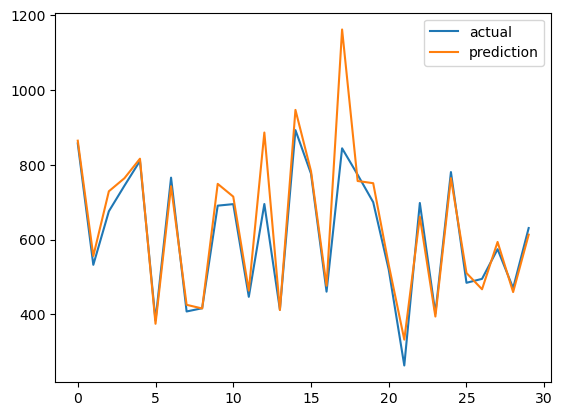

In [27]:
import matplotlib.pyplot as plt
#test_mape = mape(y_test_actual, y_test_predicted)
plt.plot(y_test, label='actual')
plt.plot(y_test_predicted, label='prediction')
plt.legend()
plt.show()
     

In [28]:
# 전체로 예측 수행
## reshape로 자료형 편집
num_samples, time_steps, num_features = Xs.shape
Xs_reshaped = Xs.reshape(num_samples, time_steps * num_features)
Xs_scaled = scaler_X.fit_transform(Xs_reshaped)

num_samples, num_time_steps = Xs_scaled.shape
num_time_steps = source_len
num_features = len(independent_list)-1
Xs_scaled = Xs_scaled.reshape(num_samples, num_time_steps, num_features)
ys = ys.reshape(-1, 1)

ys_pred = model.predict(Xs_scaled)
ys_predicted = scaler_y.inverse_transform(ys_pred)

5/5 [==============================] - 0s 4ms/step


In [29]:

# MAPE 계산
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mape(ys, ys_predicted)
print('Test MAPE:', test_mape)

test_r2 = calculate_r2_adj(ys, ys_predicted, len(independent_list))
print('R2(adj): ', test_r2)


Test MAPE: 3.956206311667296
R2(adj):  [0.95171202]


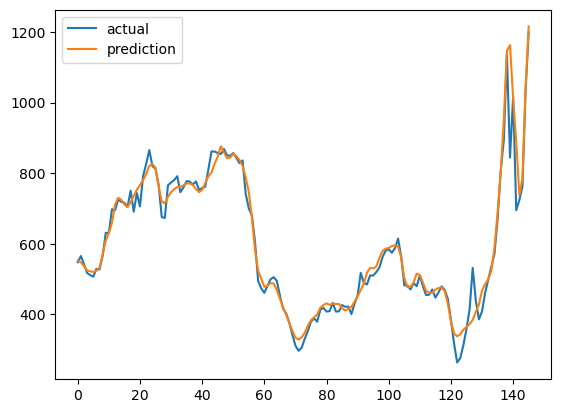

In [30]:
plt.plot(ys, label='actual')
plt.plot(ys_predicted, label='prediction')
plt.legend()
plt.show()